In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [172]:
def f(x):
    return 3*x**2 -4*x +5

h = 0.001
x = 0.66666
# derivative formula
def deriv(f, x, h):
    d = (f(x+h) - f(x))/h
    return d
# bottom of the curve
print('derivative of ',f, 'at', x, 'is', deriv(f, x, h))

derivative of  <function f at 0x7f01b2c14550> at 0.66666 is 0.0029600000002183435


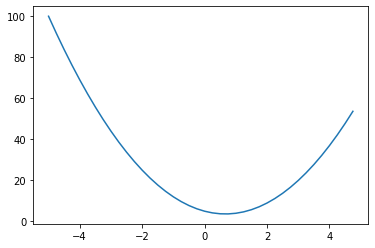

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.0001
a = 2.
b = -2.
c = 10.0
d1 = a*b +c
b += h
d2 = a*b +c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

# a 6 b -2 c 1

d1 6.0
d2 6.0001999999999995
slope 1.9999999999953388


In [181]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._op = _op
        self._prev = set(_children)
        self.label = label
        self._backward = lambda: None
        
    def __repr__(self):
        l = f'|{self.label}| ' if self.label else ''
        return l + f'v(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            # print('_backward +', self.label, self._op)
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            # print('_backward *', self.label, self._op)
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other **-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)) # int or float only
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            # print('_backward pow', self.label, self._op)
            self.grad += other * out.grad * (self.data**(other-1))
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward(): 
            # print('_backward tanh', self.label, self._op)
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            # print('_backward exp', self.label, self._op)
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        # list of nodes in topological order
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        topo.reverse()
        # print('topo', topo,'\n')
        self.grad = 1.0
        for n in topo:
            n._backward()

In [109]:
a = Value(data=1.3); a.label = 'a'
b = Value(data=2); b.label = 'b'
print(a,b)
print('a/b =', a / b)
print('a**-1 =', a**-1)

print(2 + a)
print(a + 3)
print(a.exp())

print('a-b',a-b)

|a| v(data=1.3) |b| v(data=2)
a/b = v(data=0.65)
a**-1 = v(data=0.7692307692307692)
v(data=3.3)
v(data=4.3)
v(data=3.6692966676192444)
a-b v(data=-0.7)


In [8]:
math.exp(1)

2.718281828459045

In [183]:
a = Value(2.0, label='a')
b = Value(-3, label='b')
c = Value(10.0, label='c')
e  = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

|L| v(data=-8.0)

In [177]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    print('====nodes=====')
    for n in nodes:
        print('  ***', n, id(n))
    print('===edges====')
    for e in edges:
        print('**',e, id(e[0]), id(e[1]))
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, 
                 label='{ %s | data %.4f | grad %.4f }' % (n.label, n.data, n.grad),
                 shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        e1 = str(id(n1))
        e2 = str(id(n2)) + n2._op
        dot.edge(e1, e2)
    return dot
    

In [184]:
L.backward()

====nodes=====
  *** |d| v(data=4.0) 139645271270416
  *** |L| v(data=-8.0) 139645271269408
  *** |b| v(data=-3) 139645271941296
  *** |e| v(data=-6.0) 139645271271136
  *** |f| v(data=-2.0) 139645271272864
  *** |c| v(data=10.0) 139645271944128
  *** |a| v(data=2.0) 139645271947248
===edges====
** (|f| v(data=-2.0), |L| v(data=-8.0)) 139645271272864 139645271269408
** (|c| v(data=10.0), |d| v(data=4.0)) 139645271944128 139645271270416
** (|e| v(data=-6.0), |d| v(data=4.0)) 139645271271136 139645271270416
** (|a| v(data=2.0), |e| v(data=-6.0)) 139645271947248 139645271271136
** (|b| v(data=-3), |e| v(data=-6.0)) 139645271941296 139645271271136
** (|d| v(data=4.0), |L| v(data=-8.0)) 139645271270416 139645271269408


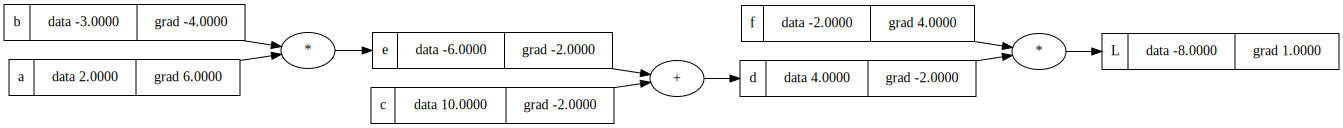

In [176]:
draw_dot(L)

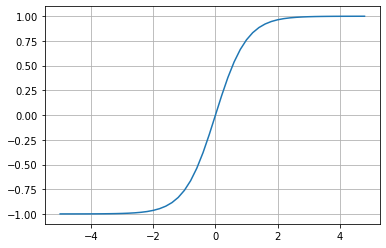

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)) ); plt.grid()


In [186]:
# neurone like expression:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.881373, label='b')
# x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# output

o = n.tanh();
# e = (2*n).exp()
# o = (e-1) / (e +1)
o.label = 'o'
o

|o| v(data=0.7071064876766542)

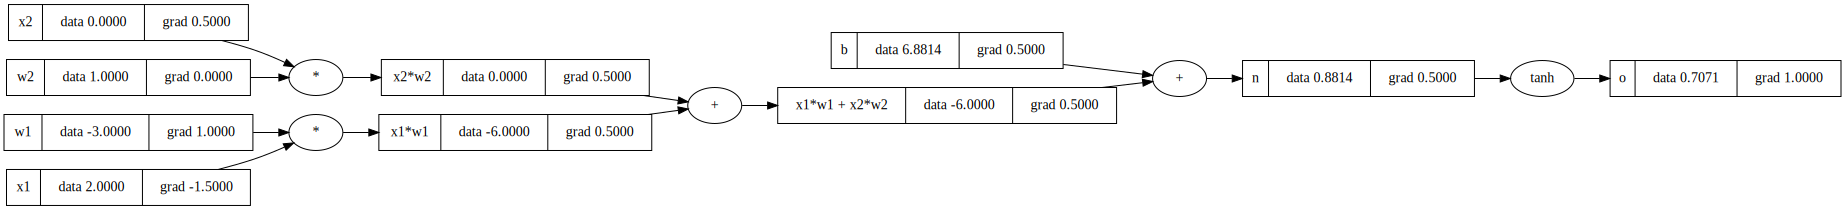

In [127]:
draw_dot(o)

In [126]:
o.backward()

topo [|o| v(data=0.7071064876766542), |n| v(data=0.881373), |b| v(data=6.881373), |x1*w1 + x2*w2| v(data=-6.0), |x2*w2| v(data=0.0), |x2| v(data=0.0), |w2| v(data=1.0), |x1*w1| v(data=-6.0), |w1| v(data=-3.0), |x1| v(data=2.0)] 

back |o| v(data=0.7071064876766542) tanh
_backward tanh n +
back |n| v(data=0.881373) +
_backward + x1*w1 + x2*w2 +
back |b| v(data=6.881373) 
_backward NONE b
back |x1*w1 + x2*w2| v(data=-6.0) +
_backward + x1*w1 *
back |x2*w2| v(data=0.0) *
_backward * x2 
back |x2| v(data=0.0) 
_backward NONE x2
back |w2| v(data=1.0) 
_backward NONE w2
back |x1*w1| v(data=-6.0) *
_backward * x1 
back |w1| v(data=-3.0) 
_backward NONE w1
back |x1| v(data=2.0) 
_backward NONE x1


In [16]:
import torch

# inputs
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
# weights
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.881373]).double(); b.requires_grad = True
x1w1x2w2 =  (x1 * w1) + (x2 * w2)
n = x1w1x2w2 + b
o = torch.tanh(n)

x = n 
print ('x1w1x2w2:', x1w1x2w2.data.item())
print('n:', o.data.item())
print('o:', o.data.item())
o.backward()
print('x1:', x1.data.item())
print('x1 grad:', x1.grad.item())
print('x2:', x2.data.item())
print('x2 grad:', x2.grad.item())

x1w1x2w2: -6.0
n: 0.7071064519863152
o: 0.7071064519863152
x1: 2.0
x1 grad: -1.500001396677975
x2: 0.0
x2 grad: 0.500000465559325


In [159]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for x in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        act = sum(wi * xi for wi, xi in zip(self.w, x))
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        """
        nb of outpouts is the same as nb of neurons
        """
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        

class Perceptron:
    def __init__(self, nin, nouts):
        """
        nin: number of inputs,
        nouts: list of layers (number of neurons per layer)
        """
        sz = [nin] + nouts # add first layer for nin inputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        """
        propagate x through successive layer
        """
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    
x = [2.0, 3.0]
n = Neuron(2)
print('neuron:', n(x))

l = Layer(2,2)
print('layer:', l(x))

ll = Layer(3,4)
print('layer 3,4:', ll(x))

mlp = Perceptron(3, [4,4,1])
o = mlp(x)
print('mlp:', o)


neuron: v(data=0.999111807759396)
layer: [v(data=-0.9966905214786191), v(data=-0.9976587739759001)]
layer 3,4: [v(data=0.9693362002022967), v(data=-0.9986520405732813), v(data=0.7770427205001931), v(data=-0.8878569317500757)]
mlp: v(data=-0.8529426075751956)


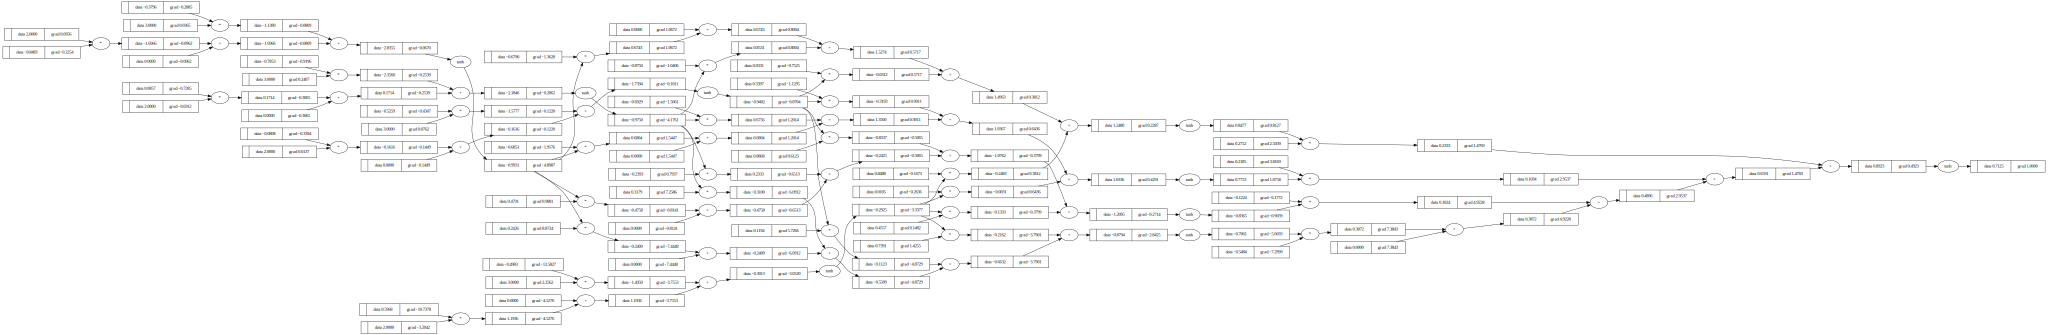

In [123]:
draw_dot(o)

In [83]:
print(len(mlp.parameters()), 'parameters:')
mlp.parameters()

41 parameters:


[v(data=-0.8482820838520624),
 v(data=-0.37964449441935955),
 v(data=0.3534048652450228),
 v(data=-0.2727620364444705),
 v(data=0.0856859949381723),
 v(data=-0.7853204125930289),
 v(data=-0.17561257013135245),
 v(data=0.13623635585031146),
 v(data=-0.08080831416206324),
 v(data=-0.525911858639978),
 v(data=0.45071031704770315),
 v(data=0.8212251749532653),
 v(data=0.5968136191382309),
 v(data=-0.4983237721488847),
 v(data=0.3118493915029632),
 v(data=-0.9771520343933129),
 v(data=0.24261213058960807),
 v(data=0.31790531421125956),
 v(data=0.1194312913614275),
 v(data=0.7391177051447659),
 v(data=0.8020210245200989),
 v(data=0.4791213360306108),
 v(data=-0.23931477067964257),
 v(data=0.8867753875393609),
 v(data=0.4556812435672586),
 v(data=0.4502063204792812),
 v(data=-0.685123565284828),
 v(data=-0.6929026628352988),
 v(data=0.3396562346286123),
 v(data=0.010539663606863536),
 v(data=0.6907072688344063),
 v(data=-0.6789634903365656),
 v(data=-0.875010654630421),
 v(data=0.033146060488

In [84]:
for p in mlp.parameters():
    p.data -= 0.01 * p.grad
mlp.parameters()

[v(data=-0.8482820838520624),
 v(data=-0.37964449441935955),
 v(data=0.3534048652450228),
 v(data=-0.2727620364444705),
 v(data=0.0856859949381723),
 v(data=-0.7853204125930289),
 v(data=-0.17561257013135245),
 v(data=0.13623635585031146),
 v(data=-0.08080831416206324),
 v(data=-0.525911858639978),
 v(data=0.45071031704770315),
 v(data=0.8212251749532653),
 v(data=0.5968136191382309),
 v(data=-0.4983237721488847),
 v(data=0.3118493915029632),
 v(data=-0.9771520343933129),
 v(data=0.24261213058960807),
 v(data=0.31790531421125956),
 v(data=0.1194312913614275),
 v(data=0.7391177051447659),
 v(data=0.8020210245200989),
 v(data=0.4791213360306108),
 v(data=-0.23931477067964257),
 v(data=0.8867753875393609),
 v(data=0.4556812435672586),
 v(data=0.4502063204792812),
 v(data=-0.685123565284828),
 v(data=-0.6929026628352988),
 v(data=0.3396562346286123),
 v(data=0.010539663606863536),
 v(data=0.6907072688344063),
 v(data=-0.6789634903365656),
 v(data=-0.875010654630421),
 v(data=0.033146060488

In [160]:
# simple example
xs = [ 
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, 1.0]
]
# desired target
ys = [1.0, -1.0, -1.0, 1.0]

ypred = [mlp(x) for x in xs]
ypred

[v(data=-0.8848403523836096),
 v(data=0.268061207589303),
 v(data=-0.5961391345734528),
 v(data=-0.5523661542329669)]

In [162]:
[ (a,b)  for a,b in zip(ys,ypred)]
loss = sum( (yout- ygt)**2 for ygt, yout in zip(ys, ypred) )
loss

v(data=7.733546655597541)